# Auto_ML

## 배경

    - 데이터 타입에 상관없이 특정 데이터 입력 시 자동으로 모델을 선정하고 성능을 평가하여 결과를 제시해 주는 autoML 역량 내재화를 목적으로 합니다.

## 사용 가능 데이터

    - 우선, table data에 대한 분석만 가능하도록 만들었으며, 추후 다양한 데이터에 대해 적용이 가능하도록 업데이트할 예정입니다.
    
    - Pycaret, autokeras, Tabnet 모델을 활용하며, 해당 모델을 구성하였습니다.
    
    - DataFrame을 Input으로 받으며, target 변수는 마지막 column에 배치
    

## 모델 사용 환경 및 세팅

    scikit-learn version 0.23.2

    tensorflow 2.5

    python 3.8 사용

    pycaret, autokeras
    
## 샘플 데이터

    - 데이터는 크게 회귀를 위한 것과 분류를 위한 것으로 나뉜다.
    
    분류 과제에서는 scikit-laern 의 iris data를 활용해 분석을 진행했다.
    
    회귀 과제에서는 skckit-learn 의 boston data를 활용해 분석을 진행했다.
    
## 실험 세팅

    - 모든 데이터에서 20 % 는 test data 로 사용하며 학습 과정에 전혀 사용하지 않고 마지막 모델들을 비교할 때만 사용하였다.
    
    - 각 학습 과정에서는 train data 를 train 과 valdiation으로 나누어 학습을 진행했다.
    
## 결과 평가

    - 분류 모델에서는 Accuracy 로, 회귀 모델에서는 Mean absolute error 로 모델을 성능을 비교했다.

## 필요 모듈 import

In [1]:
# import
from tensorflow import keras
import pycaret
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import tensorflow as tf
import autokeras as ak
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import netron

from matplotlib import pyplot as plt

from IPython.display import Image

## Classification Model

In [2]:
class Classification_model():
    
    
    def __init__(self, df):
        self.df = df
        
        
    def preprocess(self):
        target_name = self.df.columns[-1]
        
        
        # 학습에 사용될 dataset에 대한 transforamtion 진행 / 이 중 20% 를 test set 으로 사용하며 이는 학습에 사용되지 않음
        self.exp_clf = setup(data = self.df, target = target_name, transformation = True, normalize = True,
                       session_id=123, log_experiment=True, experiment_name='classification', fold_shuffle=True,
                       imputation_type='iterative', train_size = 0.8)
        
        for i in self.exp_clf:
            if isinstance(i, list):
                if len(i) > 4:
                    if i[0][0]=='Setup Config':
                        #train / test size 를 출력
                        self.X_train = i[1][1]
                        self.y_train = i[2][1]
                        self.X_test = i[3][1]
                        self.y_test = i[4][1]
                        print('X_train_shape : ', self.X_train.shape)
                        print('y_train_shape : ', self.y_train.shape)
                        print('X_test_shape : ', self.X_test.shape)
                        print('y_test_shape : ', self.y_test.shape)
        
        
        
    def pycaret_compare_models(self):
        '''
        pycaret 오픈 소스를 통한 모델 생성 및 비교
        
        accuracy 기준으로 10개 fold를 이용해 cross validation 성능이 가장 좋은 모델을 선정
        
        해당 모델을 학습 데이터에 대해 further tuning 진행
        
        추가로, 성능이 가장 좋은 모델뿐만 아니라 데이터에 대한 insight를 줄 해석 가능한 모델 ('decision tree') 또한 활용
        '''
        exp_clf = self.exp_clf
        best_model = compare_models(n_select=1)
        
        return best_model
    
    def pycaret_interpret_model(self):
        exp_clf = self.exp_clf
        dt = create_model('dt')
        
        interpret_model(dt)
        
    def pycaret_best_model(self, model):
        exp_clf = self.exp_clf
        # 가장 성능이 좋은 모델 tuning
        m1 = create_model(best_model)
        tuned_model = tune_model(m1)
        
        pred = predict_model(tuned_model)
        return pred
    
    def autokeras_model(self):
        self.y_train = self.y_train.astype('str')
        clf = ak.StructuredDataClassifier(overwrite=True, max_trials=5)
        clf.fit(self.X_train, self.y_train, epochs=50)
        predicted_y = clf.predict(self.X_test)
        model = clf.export_model()
        model.summary()
        
        return predicted_y, model
            
    
    def Tabnet_model(self):
        nunique = self.X_train.nunique()
        types = self.X_train.dtypes

        categorical_columns = []
        categorical_dims =  {}
        for col in self.X_train.columns:
            if types[col] == 'object' or nunique[col] < len(col)//4:
                # print(col, df_iris[col].nunique())
                l_enc = LabelEncoder()
                self.X_train[col] = self.X_train[col].fillna("VV_likely")
                self.X_train[col] = l_enc.fit_transform(self.X_train[col].values)
                self.X_test[col] = self.X_test[col].fillna("VV_likely")
                self.X_test[col] = l_enc.fit_transform(self.X_tset[col].values)
                categorical_columns.append(col)
                categorical_dims[col] = len(l_enc.classes_)
            else:
                self.X_train.fillna(self.X_train[col].mean(), inplace=True)
                self.X_test.fillna(self.X_test[col].mean(), inplace=True)


        # Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.

        features = [ col for col in self.X_train.columns] 
        cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
        cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

        X_train, X_val, y_train, y_val = train_test_split(self.X_train, self.y_train, test_size = 0.2, random_state=123)

        y_train = y_train.values
        X_train = X_train.values

        y_val = y_val.values
        X_val = X_val.values
        
        X_test = self.X_test.values
        
        clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )
        
        max_epochs = 100

        clf.fit(
            X_train=X_train, y_train=y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_name=['train', 'val'],
            eval_metric=['accuracy'],
            max_epochs=max_epochs , patience=20,
            batch_size=1024, virtual_batch_size=128,
            num_workers=0,
            weights=1,
            drop_last=False,
        )

        
        preds = clf.predict(X_test)
        
        return preds, clf, X_test
    
    
    def evaluate(self, pycaret_, autokeras_, tabnet_):
        '''
        각 모델들을 학습시키고 결과 비교 시작
        
        '''
        tabnet_ = np.array(tabnet_, dtype=np.float32)
        pycaret_acc = accuracy_score(pycaret_['Label'], self.y_test)
        y_test = self.y_test.astype('str')
        autokeras_acc = accuracy_score(autokeras_, y_test)
        tabnet_acc = accuracy_score(tabnet_, self.y_test)
        
        print("Accuracy for each autoML models result")
        print("Pycaret: ", pycaret_acc)
        print("Autokeras: ", autokeras_acc)
        print("Tabnet: ", tabnet_acc)

## Regression Model

In [3]:
class Regression_model():
    
    def __init__(self, df):
        self.df = df
        
        
    def preprocess(self):
        target_name = self.df.columns[-1]
        
        # 학습에 사용될 dataset에 대한 transforamtion 진행 / 이 중 20% 를 test set 으로 사용하며 이는 학습에 사용되지 않음
        self.exp_reg102 = setup(data = self.df, target = target_name, session_id=123,
                  normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  log_experiment = True, experiment_name = 'regression')
        
        for i in self.exp_reg102:
            if isinstance(i, list):
                if len(i) > 4:
                    if i[0][0]=='Setup Config':
                        #train / test size 를 출력
                        self.X_train = i[1][1]
                        self.y_train = i[2][1]
                        self.X_test = i[3][1]
                        self.y_test = i[4][1]
                        print('X_train_shape : ', self.X_train.shape)
                        print('y_train_shape : ', self.y_train.shape)
                        print('X_test_shape : ', self.X_test.shape)
                        print('y_test_shape : ', self.y_test.shape)
    
    
    def pycaret_compare_models(self):
        '''
        pycaret 오픈 소스를 통한 모델 생성 및 비교
        
        accuracy 기준으로 10개 fold를 이용해 cross validation 성능이 가장 좋은 모델을 선정
        
        해당 모델을 학습 데이터에 대해 further tuning 진행
        
        추가로, 성능이 가장 좋은 모델뿐만 아니라 데이터에 대한 insight를 줄 해석 가능한 모델 ('decision tree') 또한 활용
        '''
        exp_reg102 = self.exp_reg102
        best_model = compare_models(n_select=1)
        
        return best_model

    def pycaret_interpret_model(self):
        exp_reg102 = self.exp_reg102
        dt = create_model('dt')
        
        interpret_model(dt)
        
    def pycaret_best_model(self, model):
        exp_reg102 = self.exp_reg102
        # 가장 성능이 좋은 모델 tuning
        m1 = create_model(best_model)
        tuned_model = tune_model(m1)
        
        pred = predict_model(tuned_model)
        return pred
    
    
    def autokeras_model(self):
        y_train = np.array(self.y_train)
        X_train = np.array(self.X_train)
        clf = ak.StructuredDataRegressor(overwrite=True, max_trials=5)
        clf.fit(X_train, y_train, epochs=50)
        predicted_y = clf.predict(self.X_test.values)
        model = clf.export_model()
        model.summary()
        
        return predicted_y, model
        
   
    def Tabnet_model(self):
        nunique = self.X_train.nunique()
        types = self.X_train.dtypes

        categorical_columns = []
        categorical_dims =  {}
        for col in self.X_train.columns:
            if types[col] == 'object' or nunique[col] < len(col)//4:
                # print(col, df_iris[col].nunique())
                l_enc = LabelEncoder()
                self.X_train[col] = self.X_train[col].fillna("VV_likely")
                self.X_train[col] = l_enc.fit_transform(self.X_train[col].values)
                self.X_test[col] = self.X_test[col].fillna("VV_likely")
                self.X_test[col] = l_enc.fit_transform(self.X_tset[col].values)
                categorical_columns.append(col)
                categorical_dims[col] = len(l_enc.classes_)
            else:
                self.X_train.fillna(self.X_train[col].mean(), inplace=True)
                self.X_test.fillna(self.X_test[col].mean(), inplace=True)


        # Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.

        features = [ col for col in self.X_train.columns] 
        cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
        cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

        X_train, X_val, y_train, y_val = train_test_split(self.X_train, self.y_train, test_size = 0.2, random_state=123)

        y_train = y_train.values.reshape(-1,1)
        X_train = X_train.values

        y_val = y_val.values.reshape(-1,1)
        X_val = X_val.values
        
        X_test = self.X_test.values
        
        clf = TabNetRegressor(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )
        
        max_epochs = 100

        clf.fit(
            X_train=X_train, y_train=y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_name=['train', 'val'],
            eval_metric=['mae'],
            max_epochs=max_epochs , patience=20,
            batch_size=1024, virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
        )
        
        preds = clf.predict(X_test)
        
        return preds, clf, X_test
        
    
    def evaluate(self, pycaret_, autokeras_, tabnet_):
        '''
        각 모델들 결과 비교 시작
        '''
        tabnet_ = np.array(tabnet_, dtype=np.float32)
        pycaret_mae = mean_absolute_error(pycaret_['Label'], self.y_test)
        y_test = self.y_test
        autokeras_mae = mean_absolute_error(autokeras_, y_test)
        tabnet_mae = mean_absolute_error(tabnet_, y_test)
        
        print("Mean absolute error for each autoML models result")
        print("Pycaret: ", pycaret_mae)
        print("Autokeras: ", autokeras_mae)
        print("Tabnet: ", tabnet_mae)
    

### Sample dataset
- classification -> iris data
- regression -> boston data

In [4]:
iris = load_iris()
iris_data = np.concatenate([iris.data, iris.target.reshape(-1,1)], 1)
df_iris = pd.DataFrame(data=iris_data, columns = iris.feature_names + ['target'])

boston = load_boston()
boston_data = np.concatenate([boston.data, boston.target.reshape(-1,1)], 1)
df_boston = pd.DataFrame(boston_data, columns = list(boston.feature_names) + ['target'])

In [5]:
df = df_iris
classif_ = True
if df[df.columns[-1]].nunique() < len(df)//10:
    model = Classification_model(df)
    from pycaret.classification import *
else:
    model = Regression_model(df)
    from pycaret.regression import *
    classif_ = False

In [6]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
5,5.4,3.9,1.7,0.4,0.0
6,4.6,3.4,1.4,0.3,0.0
7,5.0,3.4,1.5,0.2,0.0
8,4.4,2.9,1.4,0.2,0.0
9,4.9,3.1,1.5,0.1,0.0


## Preprocessing

In [7]:
model.preprocess()

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(150, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


X_train_shape :  (120, 4)
y_train_shape :  (120,)
X_test_shape :  (30, 4)
y_test_shape :  (30,)


## Pycaret Model

In [8]:
best_model = model.pycaret_compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9917,0.9979,0.9917,0.9933,0.9915,0.9875,0.9884,0.0050
lr,Logistic Regression,0.9750,1.0000,0.9767,0.9797,0.9747,0.9620,0.9648,0.7690
qda,Quadratic Discriminant Analysis,0.9750,0.9979,0.9767,0.9800,0.9747,0.9624,0.9651,0.0090
nb,Naive Bayes,0.9667,0.9955,0.9683,0.9731,0.9662,0.9495,0.9532,0.0070
knn,K Neighbors Classifier,0.9583,0.9927,0.9583,0.9661,0.9575,0.9367,0.9414,0.0070
rf,Random Forest Classifier,0.9583,0.9935,0.9600,0.9664,0.9577,0.9370,0.9416,0.1090
et,Extra Trees Classifier,0.9583,1.0000,0.9600,0.9664,0.9577,0.9370,0.9416,0.0940
dt,Decision Tree Classifier,0.9500,0.9616,0.9517,0.9597,0.9493,0.9245,0.9301,0.0050
xgboost,Extreme Gradient Boosting,0.9500,0.9668,0.9517,0.9597,0.9493,0.9245,0.9301,1.0120
lightgbm,Light Gradient Boosting Machine,0.9500,0.9865,0.9517,0.9597,0.9493,0.9245,0.9301,1.3960


### Pycaret Best model

In [9]:
pred = model.pycaret_best_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9167,0.9792,0.9167,0.9333,0.9153,0.8750,0.8843
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9667,1.0000,0.9697,0.9714,0.9672,0.9482,0.9498


## Autokeras model

### Autokeras model train + model stucture

In [10]:
pred2, auto_model = model.autokeras_model()

Trial 5 Complete [00h 00m 12s]
val_accuracy: 0.9166666865348816

Best val_accuracy So Far: 0.9166666865348816
Total elapsed time: 00h 00m 59s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
4/4 [==============================] - 1s 1ms/step - loss: 0.9553 - accuracy: 0.4500
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.8867 - accuracy: 0.6083
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.8272 - accuracy: 0.6333
Epoch 4/50
4/4 [==============================] - 0s 1ms/step - loss: 0.7752 - accuracy: 0.6333
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.6333
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.6900 - accuracy: 0.6917
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 0.6550 - accuracy: 0.7167
Epoch 8/50
4/4 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.7500
Epoch 9/50
4/4 [==============================] - 0s

### Autokeras model architecture - go to the link!

In [11]:
try:
    auto_model.save("model_autokeras.h5")
except Exception:
    pass

In [12]:
netron.start('model_autokeras.h5')

Serving 'model_autokeras.h5' at http://localhost:8080


('localhost', 8080)

#### classification model picture example

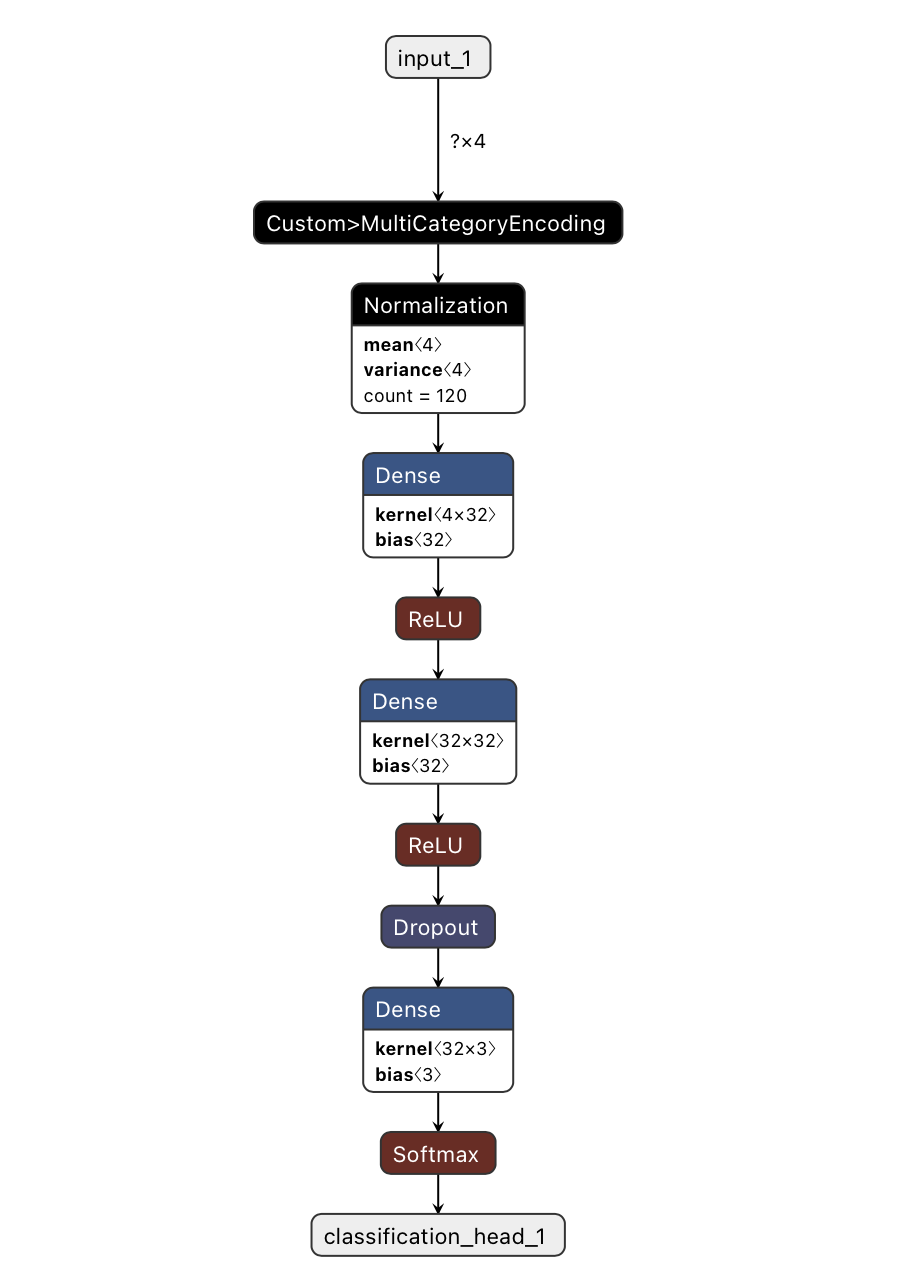

In [13]:
Image(filename='autokeras.png', width=500)

## TabNet model

### Tabnet model architecture

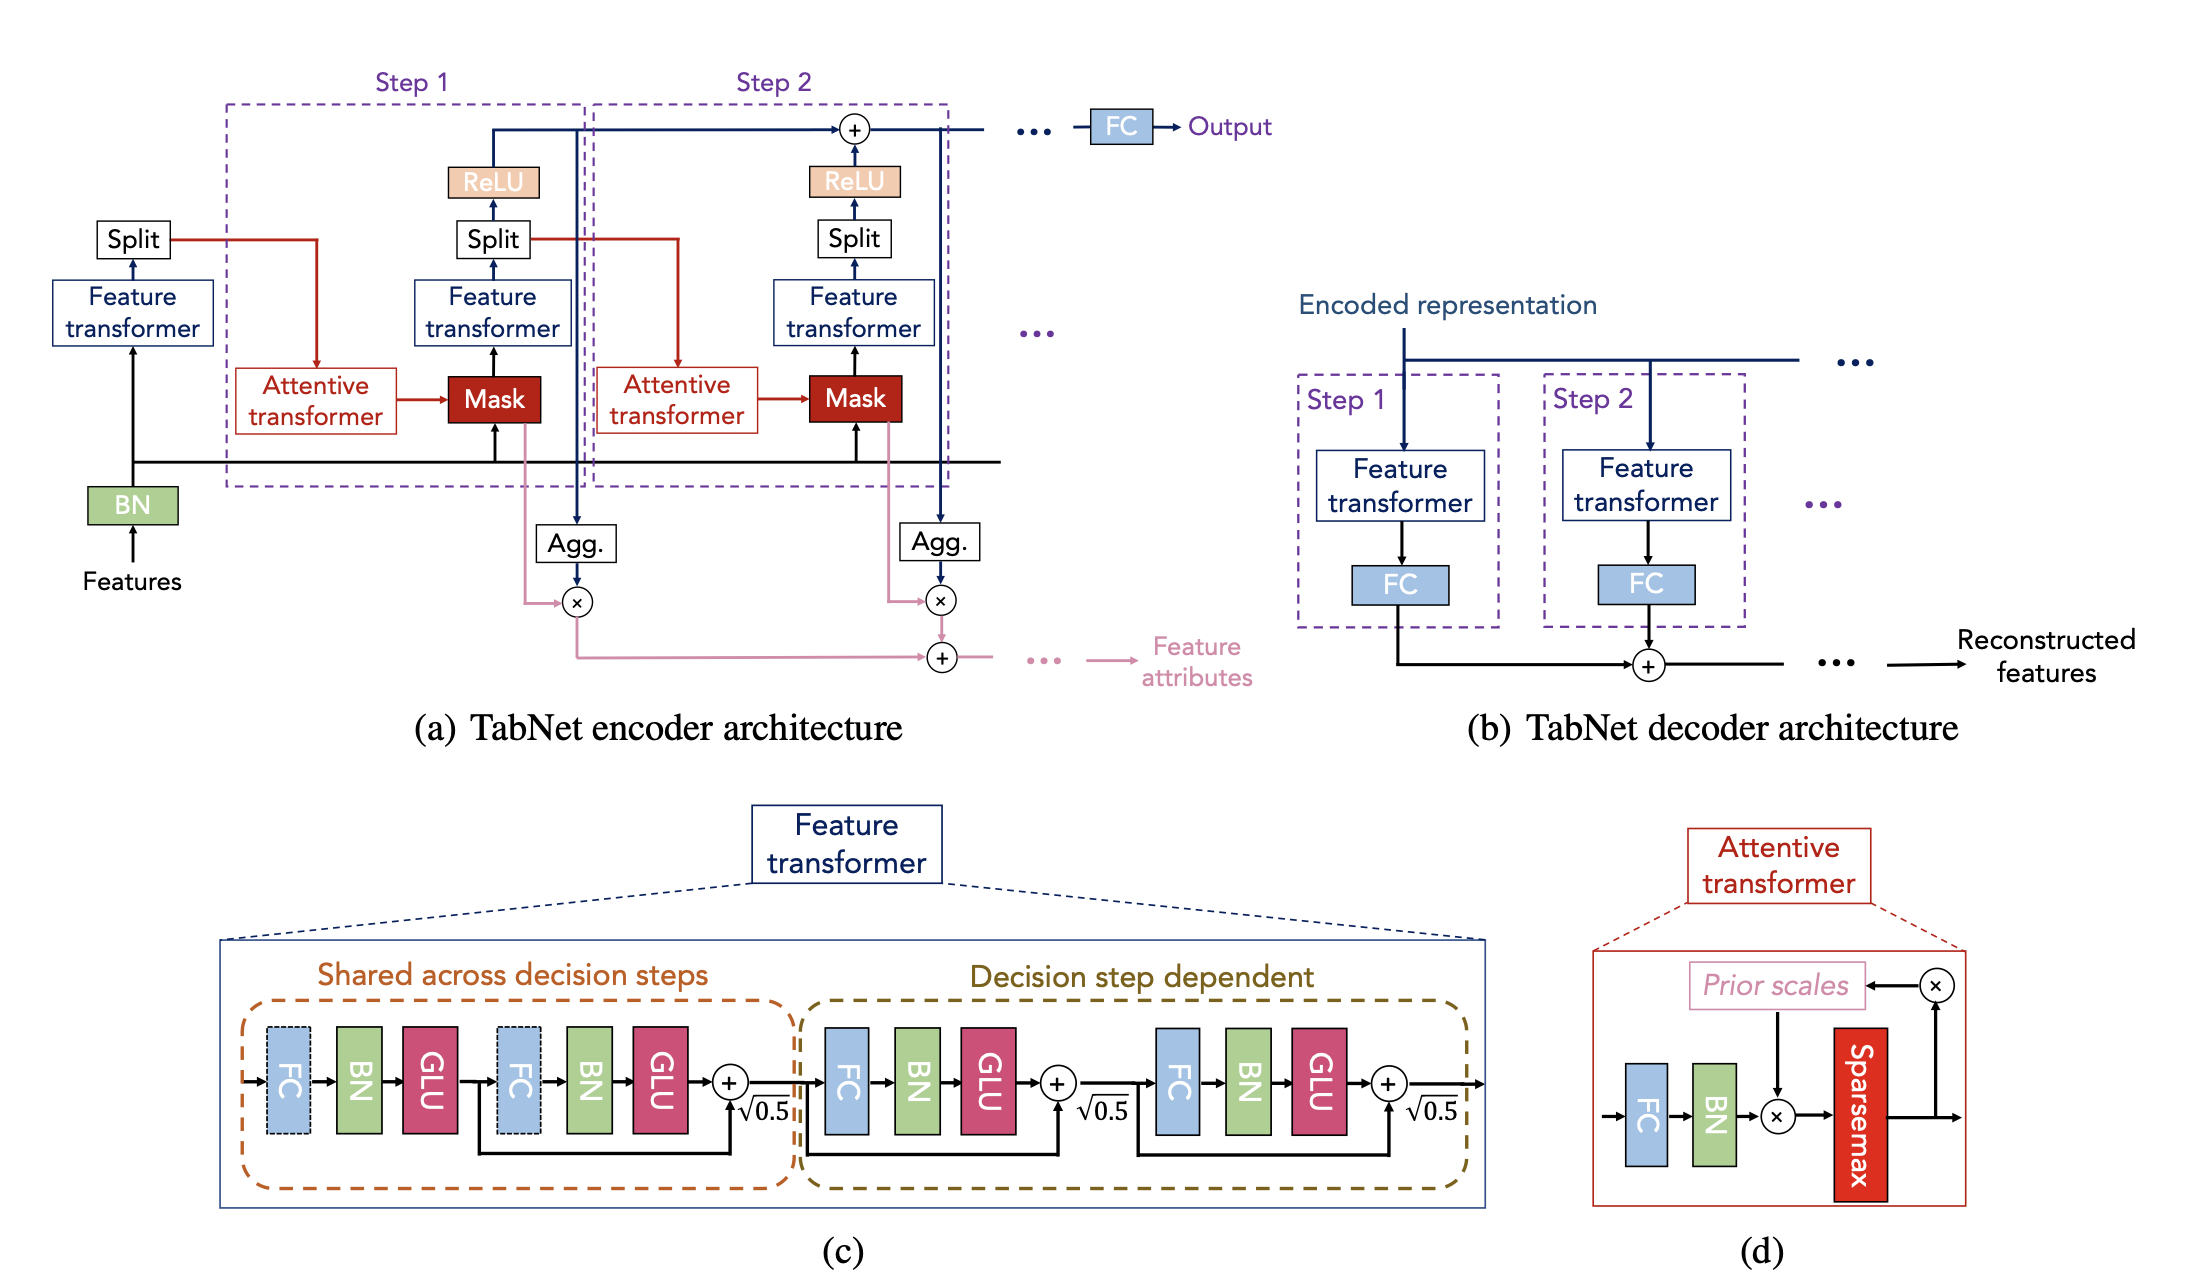

In [14]:
Image(filename='tabnet.png', width=900)

### TabNet Model Train

In [15]:
pred3, tabnet, X_test = model.Tabnet_model()

Device used : cpu
epoch 0  | loss: 1.70425 | train_accuracy: 0.3125  | val_accuracy: 0.375   |  0:00:00s
epoch 1  | loss: 1.15991 | train_accuracy: 0.3125  | val_accuracy: 0.375   |  0:00:00s
epoch 2  | loss: 1.04528 | train_accuracy: 0.40625 | val_accuracy: 0.5     |  0:00:00s
epoch 3  | loss: 0.70285 | train_accuracy: 0.58333 | val_accuracy: 0.58333 |  0:00:00s
epoch 4  | loss: 0.71968 | train_accuracy: 0.63542 | val_accuracy: 0.79167 |  0:00:00s
epoch 5  | loss: 0.65651 | train_accuracy: 0.65625 | val_accuracy: 0.83333 |  0:00:00s
epoch 6  | loss: 0.58024 | train_accuracy: 0.69792 | val_accuracy: 0.83333 |  0:00:00s
epoch 7  | loss: 0.63972 | train_accuracy: 0.67708 | val_accuracy: 0.875   |  0:00:00s
epoch 8  | loss: 0.40736 | train_accuracy: 0.71875 | val_accuracy: 0.83333 |  0:00:00s
epoch 9  | loss: 0.47151 | train_accuracy: 0.73958 | val_accuracy: 0.83333 |  0:00:00s
epoch 10 | loss: 0.43265 | train_accuracy: 0.78125 | val_accuracy: 0.875   |  0:00:00s
epoch 11 | loss: 0.35152 

## Summary

In [16]:
model.evaluate(pred, pred2, pred3)

Accuracy for each autoML models result
Pycaret:  0.9666666666666667
Autokeras:  1.0
Tabnet:  0.9666666666666667


## Model Interpretation

### Pycaret Interpretable model - Decision Tree

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9167,0.9375,0.9167,0.9333,0.9153,0.8750,0.8843
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9167,0.9375,0.9167,0.9333,0.9153,0.8750,0.8843
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9167,0.9375,0.9167,0.9333,0.9153,0.8750,0.8843
5,0.9167,0.9375,0.9167,0.9333,0.9153,0.8750,0.8843
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9167,0.9375,0.9333,0.9333,0.9167,0.8737,0.8830
8,0.9167,0.9286,0.9167,0.9306,0.9145,0.8710,0.8806
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


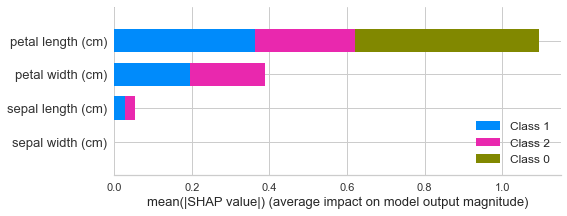

In [17]:
model.pycaret_interpret_model()

### Autokeras Interpretation

In [18]:
import lime
from lime import lime_tabular
from skimage.segmentation import mark_boundaries

In [19]:
if classif_:
    explainer = lime.lime_tabular.LimeTabularExplainer(model.X_train.values,
                                                   training_labels = model.y_train.values,
                                                   feature_names = model.X_train.columns.tolist(),
                                                   categorical_features=[],
                                                   categorical_names=[],
                                                   mode='classification')
else:
    explainer = lime.lime_tabular.LimeTabularExplainer(model.X_train.values,
                                                   training_labels = model.y_train.values,
                                                   feature_names = model.X_train.columns.tolist(),
                                                   categorical_features=[],
                                                   categorical_names=[],
                                                   mode='regression')

In [20]:
def predict(X):
    return auto_model.predict(X)


exp = explainer.explain_instance(model.X_test.iloc[0], predict, num_features=len(model.X_test.columns),
                               top_labels=1)

exp.show_in_notebook(show_table=True, predict_proba=True, show_predicted_value=True)

### TabNet Interpretation

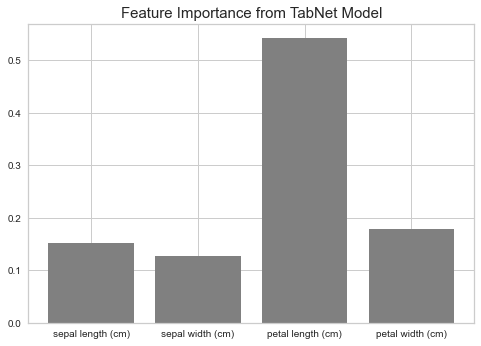

In [21]:
f = tabnet.feature_importances_
col = df.columns[:-1]

x = np.arange(len(col))
plt.bar(x, f, color='gray')
plt.xticks(x, col)
plt.title('Feature Importance from TabNet Model', size=15)
plt.show()

### Local explainability and masks

- TabNet의 저자들이 주장하는 해석력에 관한 그림

- 각 decision step 별로 어떤 Feature 들이 중요하게 사용되었는지에 대한 시각화이다.

- 예를 들어 첫 번째 decision step (mask 0) 에서는 첫 1번째 Feature가 중요하게 사용되었고, 마지막 decision step (maks 2)에서는 3, 4번째 Feature가 중요하게 사용되었으며, 특히 mask 2에서 3번째 Feature의 사용이 두드러진다.

- 해당 decision step에서 feature들의 중요도가 위의 Feature Importance에 어느 정도 반영이 되어 있다.

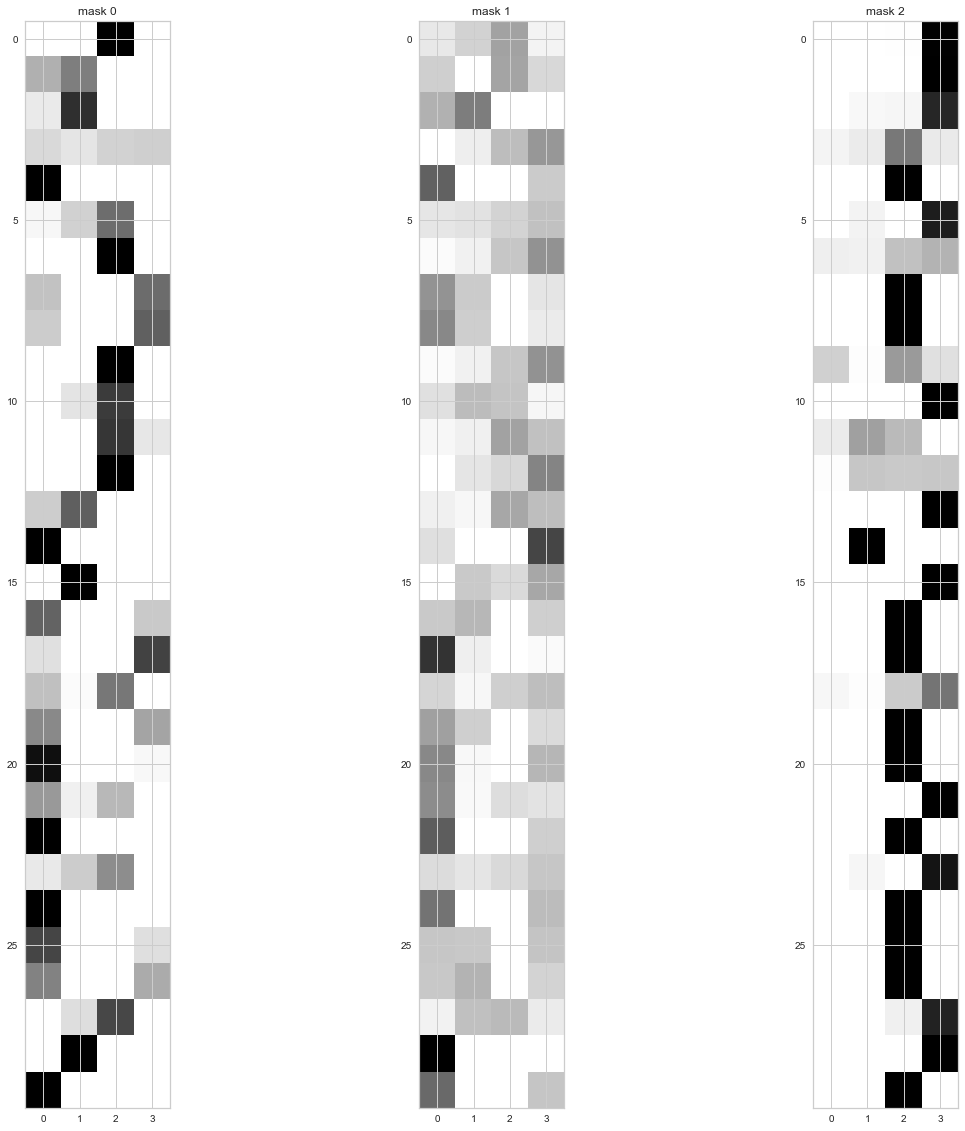

/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret/lib/python3.8/site-packa

In [22]:
explain_matrix, masks = tabnet.explain(X_test)
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")